# ML2 Project of johnjos1: Image Classification & Analysis of Watches

In [1]:
!pip install timm
!pip install pillow
!pip install urllib.request
!pip install torch
!pip install keras
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement urllib.request (from versions: none)
ERROR: No matching distribution found for urllib.request
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## short EDA

I have a dataset from [Kaggle](https://www.kaggle.com/datasets/ahedjneed/fancy-watche-images/versions/4?resource=download), that provides watch images from different brands



First Mount Google Drive (file has to be shared to other student or can download from kaggle and save on its own drive with root-foldername "watches")

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data_dir = '/content/drive/MyDrive/watches/data'


I know display 10 random images from each brand just to look at the data and see if the picutres are legit. (didn't set a seed)

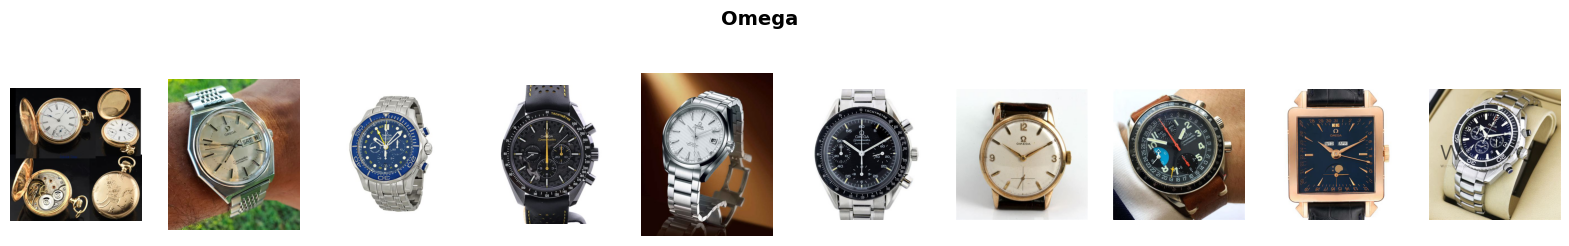

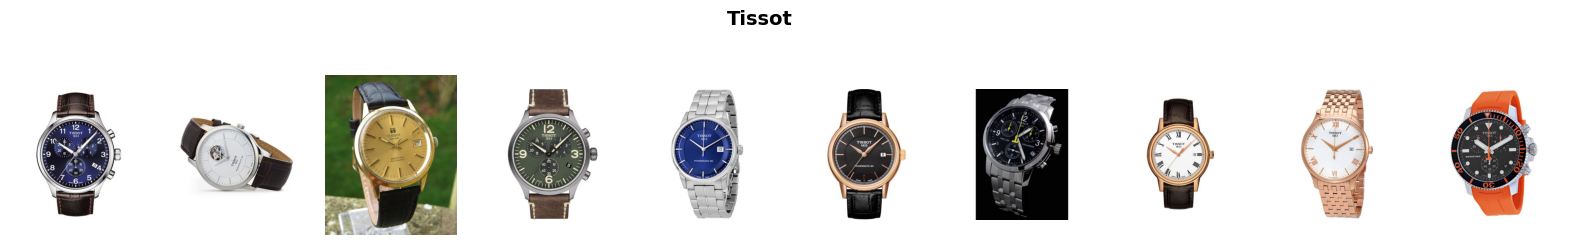

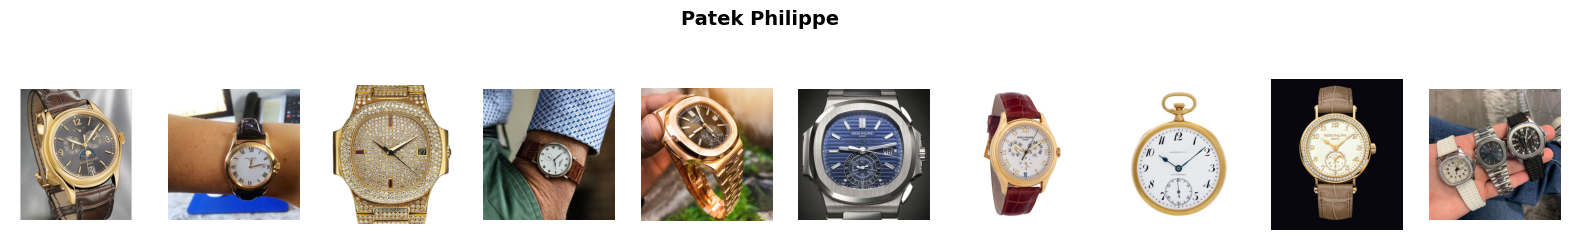

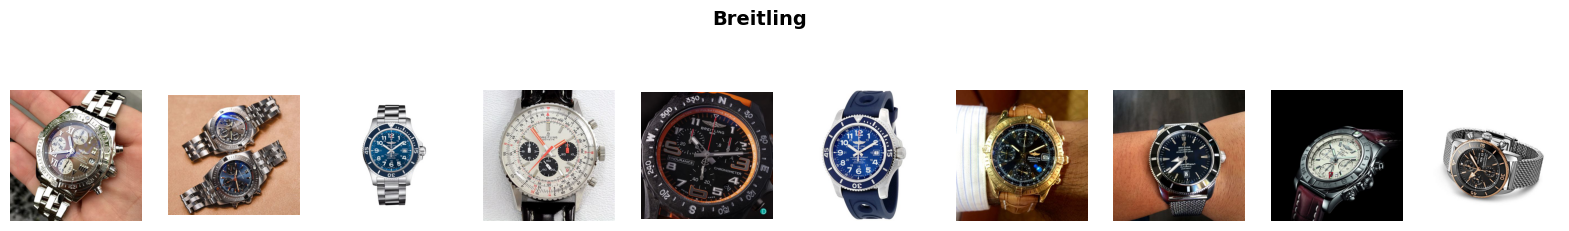

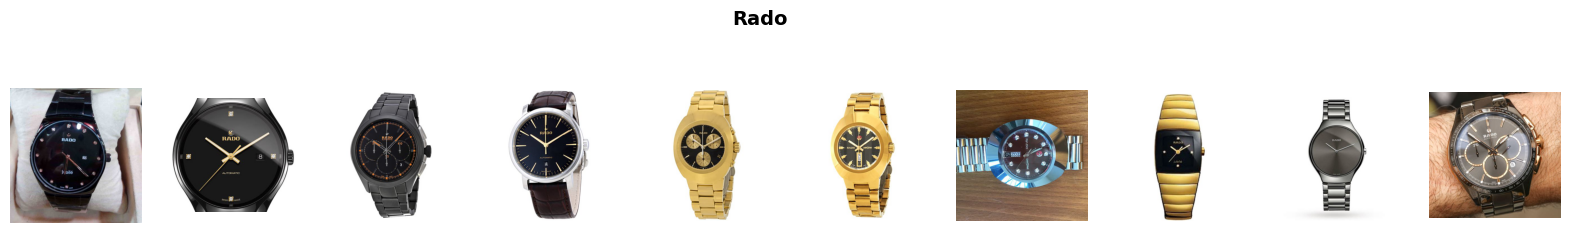

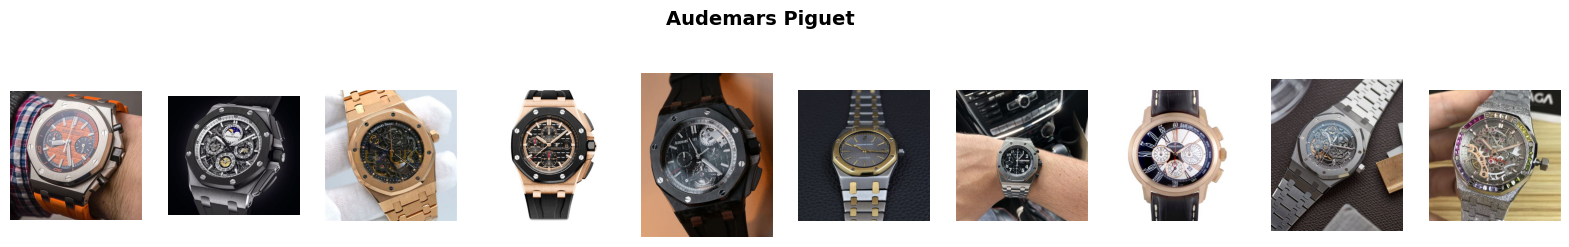

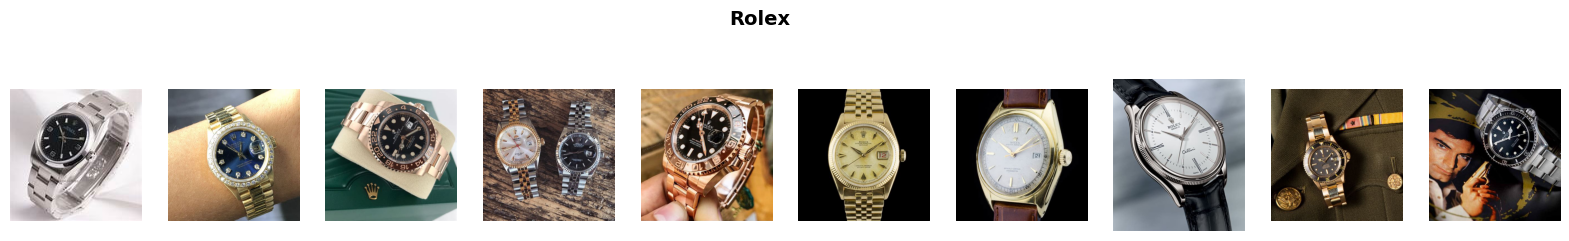

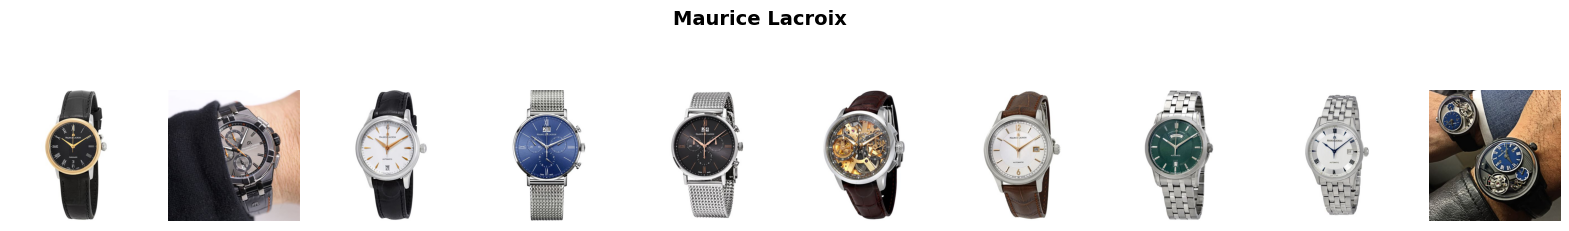

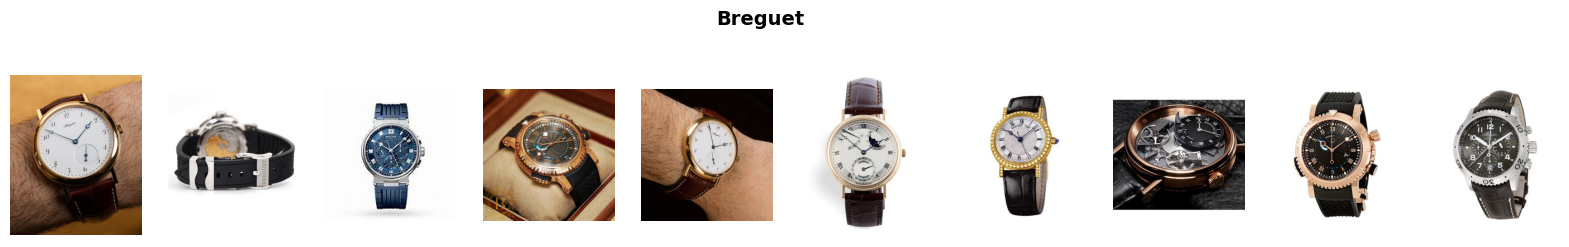

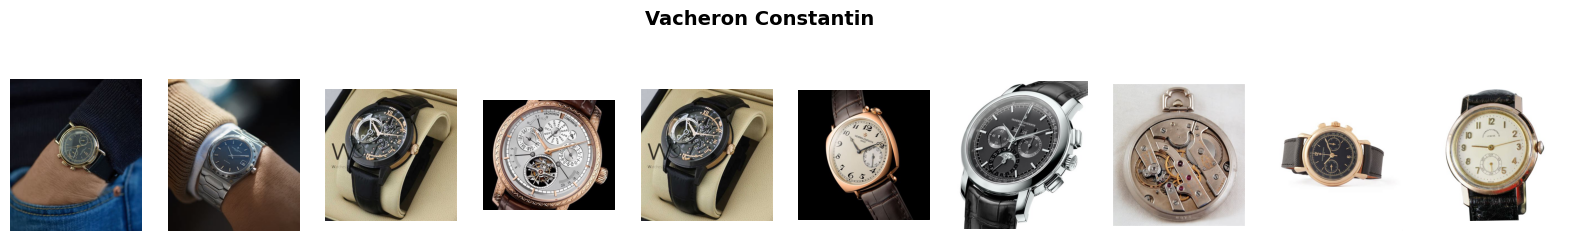

In [3]:
import os
import glob
import random
import matplotlib.pyplot as plt

data_dir = '/content/drive/MyDrive/watches/data'

brands = os.listdir(data_dir)

num_images_per_class = 10

for brand in brands:
    image_files = glob.glob(os.path.join(data_dir, brand, "*.jpg"))
    random.shuffle(image_files)
    selected_images = image_files[:num_images_per_class]

    fig, axs = plt.subplots(nrows=1, ncols=num_images_per_class, figsize=(20, 3))
    fig.suptitle(brand, fontsize=14, fontweight='bold')

    for i, image_file in enumerate(selected_images):
        image = plt.imread(image_file)
        axs[i].imshow(image)
        axs[i].axis('off')

    plt.show()


The pictures look good, eventough some show multiple watches, some are stand alone, worn on the wrist or in a watch-box, some are bit more zoomed in or zoomed out, but I think that's okay.

Let us see how many images there are for each brand, to check if the classes are balanced.

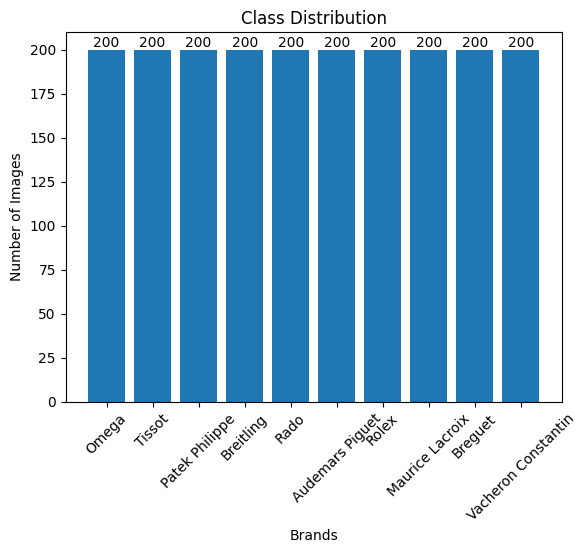

In [4]:
class_counts = [len(glob.glob(os.path.join(data_dir, brand, "*.jpg"))) for brand in brands]

plt.bar(brands, class_counts)
plt.xlabel("Brands")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.xticks(rotation=45)

# Add count labels on top of each bar
for i, count in enumerate(class_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()


As we can see the data set is fully balanced each brand contains exactly 200 pictures

## Data Augmentation



### Data Gen, not working ????

In [5]:
original_images_dir = '/content/drive/MyDrive/watches/data'
augmented_images_dir = '/content/drive/MyDrive/augmented/watches/data'


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with desired augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Define the path to your original images
original_images_dir = '/content/drive/MyDrive/watches/data'

# Generate augmented images and save them to a directory
augmented_images_dir = '/content/drive/MyDrive/augmented/watches/data'
augmented_data_generator = datagen.flow_from_directory(
    original_images_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# # Iterate over the augmented_data_generator to generate and process the augmented images
# for i in range(2000 // 32):
#     images, labels = next(augmented_data_generator)
#     # Process the augmented images and labels as needed
#     # Your model training code goes here


Found 2000 images belonging to 10 classes.


### Data augmentation demo
I tried [various preprocessing classes](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) and chose the one below, because these are the ones that make sence for image data

In [16]:
import tensorflow as tf

with tf.device('/cpu:0'):  # This line is essential only if you are using an M1 Processor
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal_and_vertical'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.4), #or less zoom
        tf.keras.layers.RandomCrop(1024, 1024),
        tf.keras.layers.CenterCrop(1024, 1024),
        tf.keras.layers.Resizing(224, 224),
    ])


In [17]:
img =  tf.keras.utils.load_img('/content/drive/MyDrive/watches/data/Audemars Piguet/019_af4b8c96.jpg')
#img = tf.cast(tf.expand_dims(img, 0), tf.float32)
img = tf.expand_dims(img, 0)

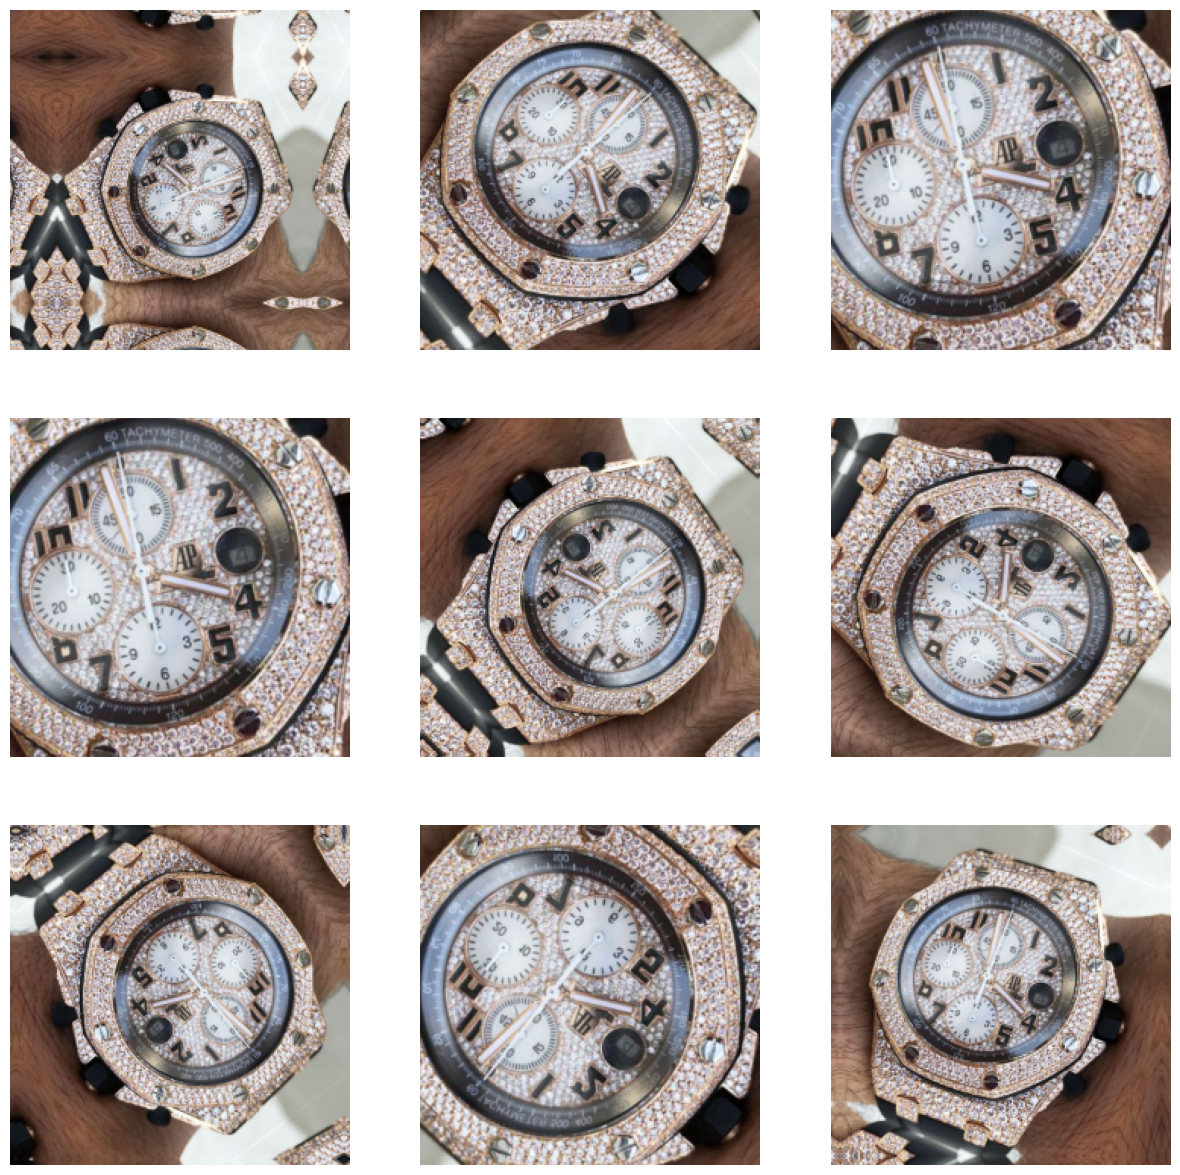

In [18]:
import matplotlib.pyplot as plt

with tf.device('/cpu:0'):
    plt.figure(figsize=(15, 15))
    for i in range(9):
      augmented_image = data_augmentation(img)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_image[0] / 255)
      plt.axis("off")

## Data

Creating a training, test & validation dataset

My data is structured in folders and Subfolders, so the model can easily detect the classes.

In [25]:
data_dir = os.path.join(os.curdir, '/content/drive/MyDrive/watches/data')

BATCH_SIZE = 32
IMG_SIZE = (192, 192)

# Split the data into training, validation, and test sets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=777,
    validation_split=0.20,
    subset="training"
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=999,
    validation_split=0.20,
    subset="validation"
)

# Determine the number of samples for validation and test sets
validation_batches = tf.data.experimental.cardinality(validation_dataset)
test_batches = validation_batches // 5

# Split the validation dataset into validation and test sets
validation_dataset = validation_dataset.skip(test_batches)
test_dataset = validation_dataset.take(test_batches)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Found 2000 files belonging to 10 classes.
Using 1600 files for training.
Found 2000 files belonging to 10 classes.
Using 400 files for validation.
Number of validation batches: 11
Number of test batches: 2


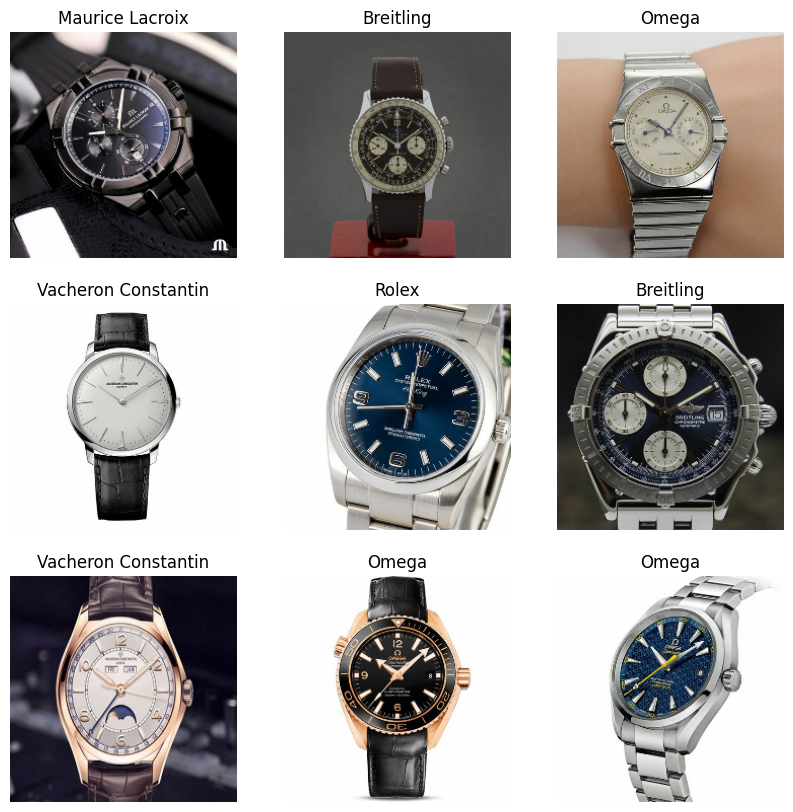

In [23]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

image = os.path.join(os.curdir, '/content/drive/MyDrive/watches/data')
# Define the chosen model
chosen_model = "xception"  # Set this to "vgg", "xception", or "visual_transformer" based on your choice

# Define your preprocessing functions
def preprocess_vgg(image):
    return tf.keras.applications.vgg16.preprocess_input(image)

def preprocess_xception(image):
    return tf.keras.applications.xception.preprocess_input(image)

def preprocess_visual_transformer(image):
    image = tf.image.resize(image, (224, 224))  # Resize to the required input shape
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image

# Load and preprocess the data
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

if chosen_model == "vgg":
    train_dataset = train_dataset.map(lambda x, y: (preprocess_vgg(x), y))
    val_dataset = val_dataset.map(lambda x, y: (preprocess_vgg(x), y))
elif chosen_model == "xception":
    train_dataset = train_dataset.map(lambda x, y: (preprocess_xception(x), y))
    val_dataset = val_dataset.map(lambda x, y: (preprocess_xception(x), y))
else:
    train_dataset = train_dataset.map(lambda x, y: (preprocess_visual_transformer(x), y))
    val_dataset = val_dataset.map(lambda x, y: (preprocess_visual_transformer(x), y))

# Define and compile the models
if chosen_model == "vgg":
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
elif chosen_model == "xception":
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
else:
    # Define your Visual Transformer model architecture here

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(256, activation='relu')(x)
  predictions = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs=base_model.input, outputs=predictions)

  # Compile the model
  model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
batch_size = 32
epochs = 10

# # Data augmentation (optional)
# data_gen = ImageDataGenerator(rotation_range=20, zoom_range=0.2, horizontal_flip=True)

# Apply data augmentation to the training dataset
train_dataset_augmented = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) #We need to set `training=False` as our model contains a `BatchNormalization` layer. More explanation here https://www.tensorflow.org/guide/keras/transfer_learning
x = tf.keras.layers.GlobalAveragePooling2D()(x) #this layer has the same purpose as tf.keras.layers.Flatten(). Need to connect something 2D to something 1D. Ask if you want to know more :)
#x = tf.keras.layers.Dense(10, activation="relu")(x)
#x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Dense(5, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="softmax")(x) 
model = tf.keras.Model(inputs, outputs)


base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

# Train the model
model.fit(train_dataset_augmented.batch(batch_size), epochs=epochs, validation_data=val_dataset.batch(batch_size))


NameError: ignored

In [ ]:
results = model.evaluate(val_dataset.batch(batch_size))
print("Validation Accuracy: {:.2f}%".format(results[1] * 100))
print("Validation Loss: {:.4f}".format(results[0]))


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
import keras

model = keras.applications.xception.Xception(weights='imagenet', include_top= False)

# avg = keras. layers.GlobalAveragePooling2D()(base_model.output)
# output = keras.layers.Dense(n_classes, activation="softmax")(avg)
# model= keras.models.Model(inputs=base_model.input, outputs=output)

# for layer in base_model.layers:
#     layer.trainbale=False

# optimizer = keras.optimizer.SGD(lr=0.2, momentum=0.9, decay=0.01)
# model.compile(loss="sparse_categorical_corssentropy", optimizer=optimizer, metrics=["accuracy"])
# history = model.fit


First I want to load two pretrained model to see how they would perform just so.
My idea was to load a ViT-Model and the one of the newer better performing models like senet, vgg or Xception. I tend to Xception, because according to the [keras webpage](https://keras.io/api/applications/) it performs really good eventhough it's not such a big model (MB)

CNN normally work good on small data sets
an exception is this thread that explains [ViT for small datasets](https://keras.io/examples/vision/vit_small_ds/)



In [ ]:
from urllib.request import urlopen
from PIL import Image
import timm
import torch

# Load the image from the URL
#img = Image.open(urlopen('https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'))
img = Image.open('/content/drive/MyDrive/watches/data/Audemars Piguet/001_90921d4b.jpg')

# Create and load the pre-trained model
model = timm.create_model('senet154', pretrained=True)
model = model.eval()

# Get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

# Apply transformations and feed the image through the model
input_tensor = transforms(img).unsqueeze(0)  # Unsqueeze single image into a batch of 1
output = model(input_tensor)

# Calculate the top 5 probabilities and class indices
top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)

# Print the top 5 predicted class labels and their probabilities
for i in range(5):
    class_index = top5_class_indices[0][i]
    probability = top5_probabilities[0][i]
    print(f"Class index: {class_index}, Probability: {probability:.2f}%")


Class index: 826, Probability: 75.80%
Class index: 531, Probability: 7.20%
Class index: 409, Probability: 1.87%
Class index: 635, Probability: 0.44%
Class index: 464, Probability: 0.37%


# New Section